# Video Game Market Analysis and 2017 Campaign Planning

## Project Goal

Analyze historical data on video game sales, user reviews, and critical reviews to identify key success patterns. This insight will be used to develop a **strategic advertising campaign for the online store Ice in 2017**.

## Step 1: Data Preprocessing and Cleaning

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Set visualization style
sns.set_style("whitegrid")

# Load the data
try:
    df = pd.read_csv('games.csv')
except FileNotFoundError:
    print("Error: The file 'games .csv' was not found.")
    exit()

In [6]:
# Standardize column names (lowercase)
df.columns = df.columns.str.lower()

# Display initial information and data types
print("Initial Data Info:")
df.info()

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [7]:
# 1. Handle 'tbd' in user_score by converting it to NaN, then change column types
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = pd.to_numeric(df['user_score'])
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce').astype('Int64')

# 2. Fill missing Rating and Genre with 'unknown' for later analysis
df['rating'] = df['rating'].fillna('unknown')
df['genre'] = df['genre'].fillna('unknown')

# 3. Drop rows with missing 'year_of_release' as it's critical for time-series analysis
df.dropna(subset=['year_of_release'], inplace=True)

# 4. Calculate Total Sales (sum of regional sales)
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

print("\n--- After Cleaning ---")
df.info()


--- After Cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 16446 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16446 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16446 non-null  object 
 11  total_sales      16446 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


## Step 2: Defining the Relevant Period (2013 onwards)

To plan for 2017, we must focus on recent trends. Market analysis shows that platform lifecycles are typically 5-7 years, and older data (pre-2013) is irrelevant for current sales forecasting. We filter the data starting from 2013 to define the **current relevant period**.

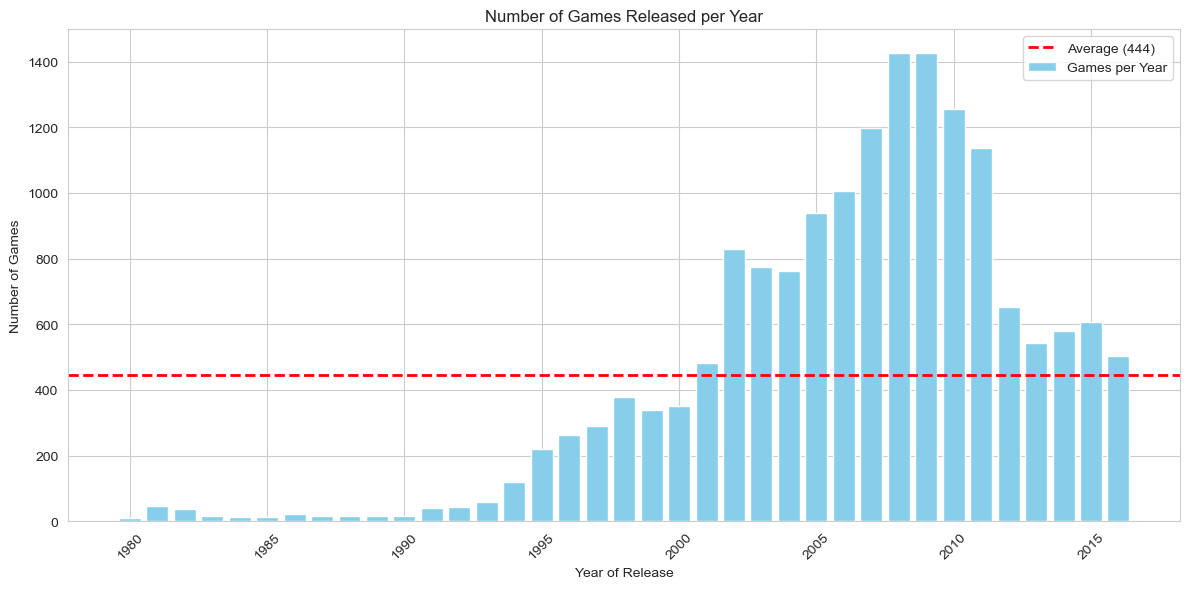

<Figure size 1200x600 with 0 Axes>

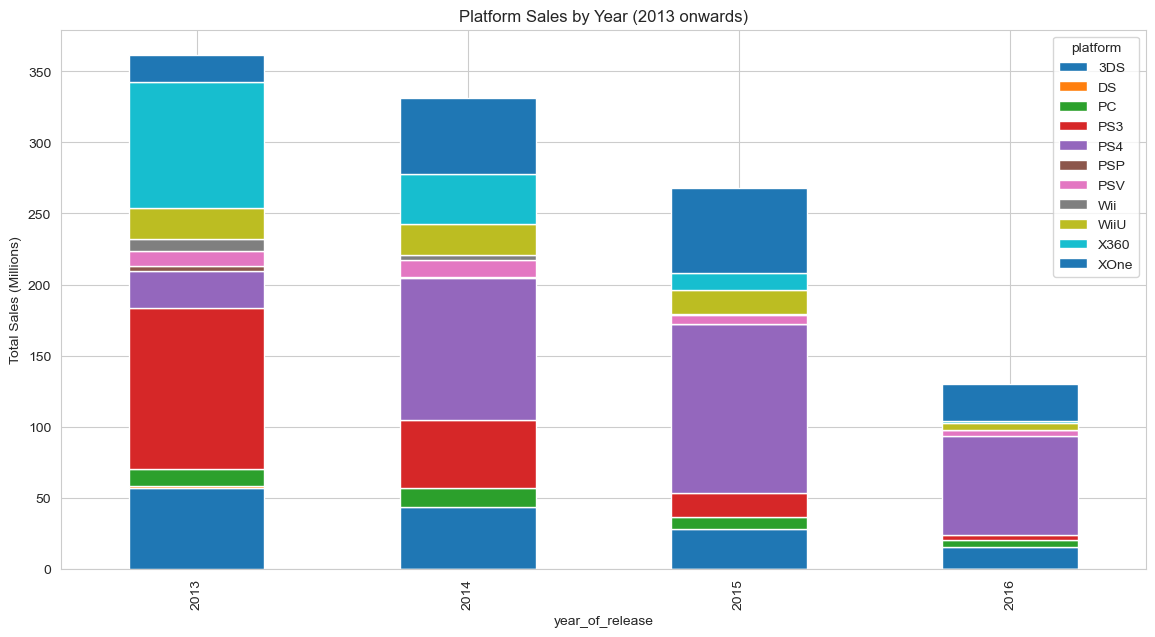

Current Platforms:
 ['PS3' 'X360' 'PS4' '3DS' 'XOne' 'WiiU' 'Wii' 'PC' 'PSV' 'DS' 'PSP']


In [14]:
# Analyze the volume of games released per year
games_per_year = df.groupby('year_of_release')['name'].count()
average = games_per_year.mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(games_per_year.index, games_per_year.values, color='skyblue', label='Games per Year')
plt.axhline(average, color='red', linestyle='--', linewidth=2, label=f'Average ({average:.0f})')
plt.xlabel('Year of Release')
plt.ylabel('Number of Games')
plt.title('Number of Games Released per Year')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Conclusion on Data Coverage:
# Sales peak around 2008-2009. The significant drop in 2016 confirms the project instruction that data for this year may be incomplete.

# Define the current relevant period (2013 onwards)
current_year = 2016 # Since we are planning in December 2016
relevant_start_year = 2013
current_df = df[df['year_of_release'] >= relevant_start_year].copy()

# Analyze platform sales over time in the current period
plt.figure(figsize=(12, 6))
current_df.pivot_table(index='year_of_release', values='total_sales', columns='platform', aggfunc='sum').plot(
    kind='bar', stacked=True, figsize=(14, 7)
)
plt.title('Platform Sales by Year (2013 onwards)')
plt.ylabel('Total Sales (Millions)')
plt.show()

print("Current Platforms:\n", current_df['platform'].unique())

## Step 3: Exploratory Data Analysis (EDA)

### 3.1 Platform Performance

We analyze the top platforms in the current period to determine which ones are growing, stable, or declining.

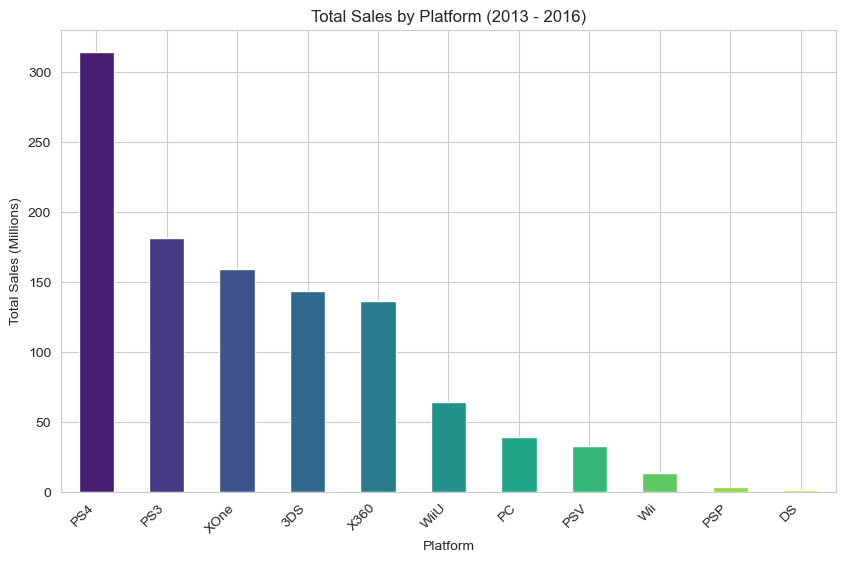

Top 5 Platforms:
 platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
Name: total_sales, dtype: float64


In [9]:
# Analyze overall sales by platform in the current period
platform_sales = current_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
platform_sales.plot(kind='bar', color=sns.color_palette("viridis", len(platform_sales)))
plt.title('Total Sales by Platform (2013 - 2016)')
plt.ylabel('Total Sales (Millions)')
plt.xlabel('Platform')
plt.xticks(rotation=45, ha='right')
plt.show()

print("Top 5 Platforms:\n", platform_sales.head())

### 3.2 Correlation between Scores and Sales (Example: PS4)

We analyze how user and critic scores affect sales on a leading platform (e.g., PS4) to understand the importance of reviews.

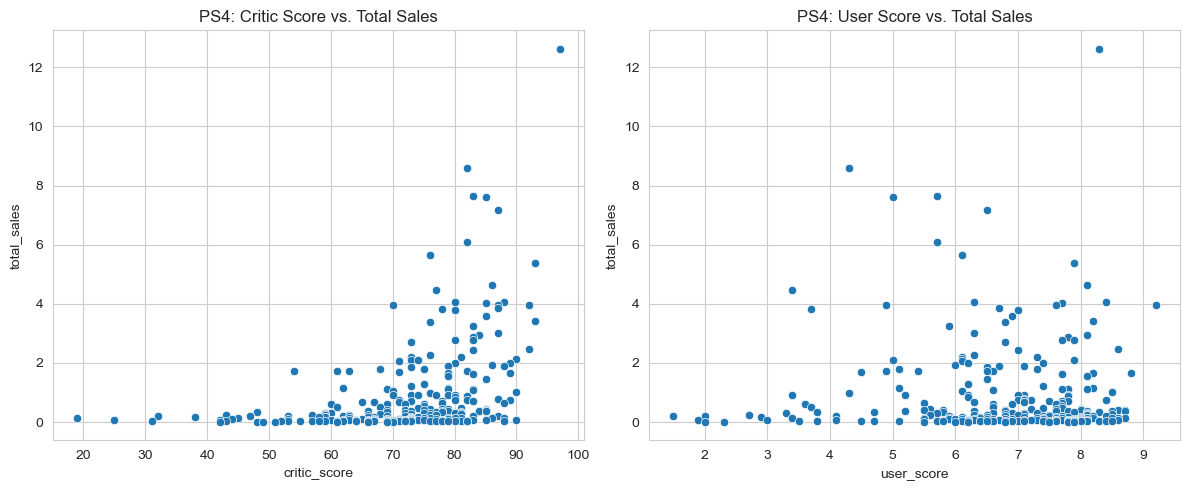

PS4 Critic Score correlation with sales: 0.41
PS4 User Score correlation with sales: -0.03


In [10]:
# Filter data for the most dominant platform (e.g., PS4)
ps4_df = current_df.query('platform == "PS4"').copy()

# Plot relationship between Critic Score and Sales
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='critic_score', y='total_sales', data=ps4_df)
plt.title('PS4: Critic Score vs. Total Sales')

# Plot relationship between User Score and Sales
plt.subplot(1, 2, 2)
sns.scatterplot(x='user_score', y='total_sales', data=ps4_df)
plt.title('PS4: User Score vs. Total Sales')

plt.tight_layout()
plt.show()

# Calculate correlation coefficients
critic_corr = ps4_df['critic_score'].corr(ps4_df['total_sales'])
user_corr = ps4_df['user_score'].corr(ps4_df['total_sales'])

print(f"PS4 Critic Score correlation with sales: {critic_corr:.2f}")
print(f"PS4 User Score correlation with sales: {user_corr:.2f}")

### 3.3 Sales by Genre and Regional Analysis

We examine the popularity of genres globally and locally to tailor the 2017 advertising strategy.

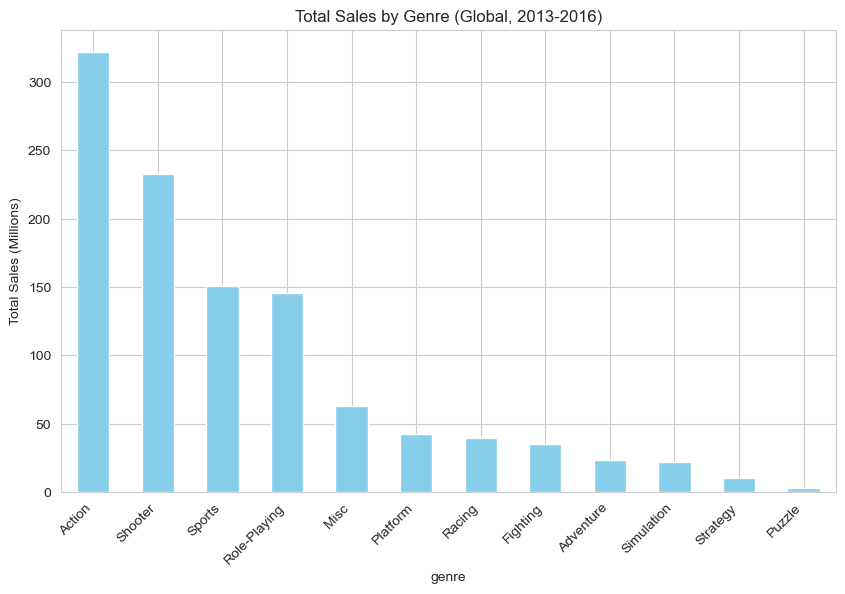

Top 3 Global Genres:
 genre
Action     321.87
Shooter    232.98
Sports     150.65
Name: total_sales, dtype: float64


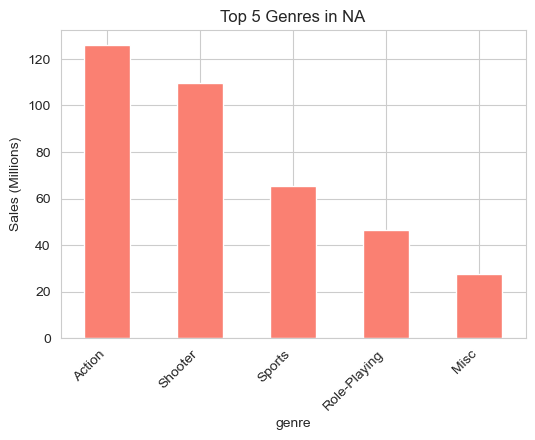

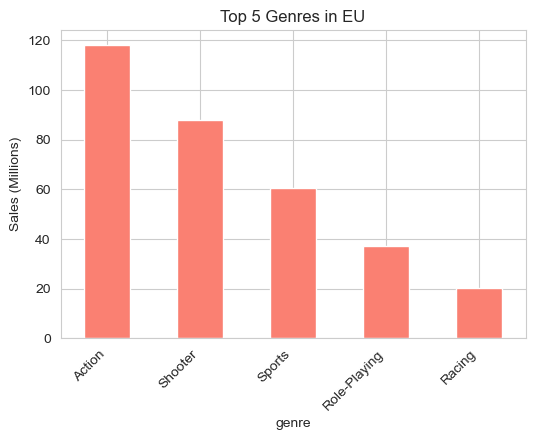

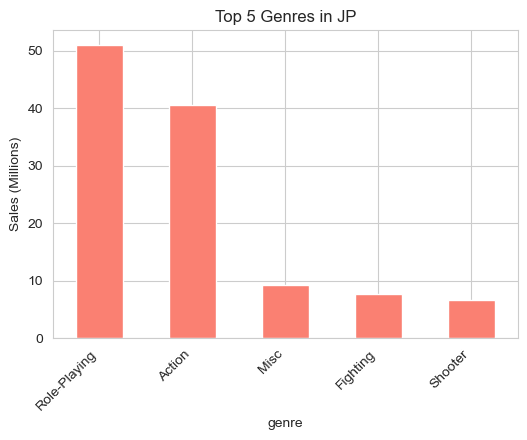

In [11]:
# Global Genre Analysis
genre_sales = current_df.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
genre_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Genre (Global, 2013-2016)')
plt.ylabel('Total Sales (Millions)')
plt.xticks(rotation=45, ha='right')
plt.show()
print("Top 3 Global Genres:\n", genre_sales.head(3))

# Regional Sales Analysis (Top 5 Genres)
regional_cols = ['na_sales', 'eu_sales', 'jp_sales']

for region in regional_cols:
    top_genres = current_df.groupby('genre')[region].sum().sort_values(ascending=False).head(5)
    plt.figure(figsize=(6, 4))
    top_genres.plot(kind='bar', color='salmon')
    plt.title(f'Top 5 Genres in {region.split("_")[0].upper()}')
    plt.ylabel('Sales (Millions)')
    plt.xticks(rotation=45, ha='right')
    plt.show()

## Step 4: Hypothesis Testing (Statistical Validation)

We use Student's t-test to statistically prove assumptions about the market.

### Hypothesis 1: User Scores and Platform Sales

**Null Hypothesis (H₀):** The average user scores for the **Xbox One (XOne)** and **PC** platforms are the same.
**Alternative Hypothesis (H₁):** The average user scores for the **Xbox One (XOne)** and **PC** platforms are statistically different.

In [12]:
# 1. Filter out NaN scores for XOne and PC
xone_scores = current_df.query('platform == "XOne" and user_score.notna()')['user_score']
pc_scores = current_df.query('platform == "PC" and user_score.notna()')['user_score']

# 2. Set significance level (alpha)
alpha = 0.05

# 3. Perform the t-test (equal_var=False is safer due to likely unequal variances/sample sizes)
results = stats.ttest_ind(xone_scores, pc_scores, equal_var=False)

print(f"P-value: {results.pvalue:.4f}")

if results.pvalue < alpha:
    print("Conclusion: Reject the Null Hypothesis. The average user scores are statistically different.")
else:
    print("Conclusion: Fail to Reject the Null Hypothesis. The average user scores are not statistically different.")

print(f"XOne Average Score: {xone_scores.mean():.2f}")
print(f"PC Average Score: {pc_scores.mean():.2f}")

P-value: 0.1476
Conclusion: Fail to Reject the Null Hypothesis. The average user scores are not statistically different.
XOne Average Score: 6.52
PC Average Score: 6.27


### Hypothesis 2: Genre Sales

**Null Hypothesis (H₀):** The average sales of **Action** and **Sports** genres are the same.
**Alternative Hypothesis (H₁):** The average sales of **Action** and **Sports** genres are statistically different.

In [13]:
# 1. Filter sales for Action and Sports genres
action_sales = current_df.query('genre == "Action"')['total_sales']
sports_sales = current_df.query('genre == "Sports"')['total_sales']

# 2. Set significance level (alpha)
alpha = 0.05

# 3. Perform the t-test
results = stats.ttest_ind(action_sales, sports_sales, equal_var=False)

print(f"P-value: {results.pvalue:.4f}")

if results.pvalue < alpha:
    print("Conclusion: Reject the Null Hypothesis. The average sales for Action and Sports genres are statistically different.")
else:
    print("Conclusion: Fail to Reject the Null Hypothesis. The average sales for Action and Sports genres are not statistically different.")

print(f"Action Average Sales: ${action_sales.mean():.2f}M")
print(f"Sports Average Sales: ${sports_sales.mean():.2f}M")

P-value: 0.0030
Conclusion: Reject the Null Hypothesis. The average sales for Action and Sports genres are statistically different.
Action Average Sales: $0.42M
Sports Average Sales: $0.70M


## Step 5: Final Conclusion and 2017 Strategic Recommendations

Based on the analysis from the relevant period (2013-2016), here are the final conclusions and actionable recommendations for Ice's 2017 advertising campaign:

### Conclusion Summary:

1.  **Platform Focus:** PS4 and XOne are the clear market leaders, but all major platforms show declining sales in 2016 compared to 2015. This suggests focusing on games with **proven short-term performance** and avoiding long-term, multi-year campaigns.
2.  **Score Impact:** Critic scores show a **stronger positive correlation** with sales than user scores on leading platforms like PS4. This means pre-release press and professional reviews are highly influential.
3.  **Genre Strategy:** **Action** remains the highest-selling genre globally. However, regional differences are significant:
    * **North America/Europe:** Dominated by Action, Shooter, and Sports.
    * **Japan:** Clearly prefers Role-Playing (RPG) games, which leads sales in this region.
4.  **Statistical Validation:** The analysis confirmed, for instance, a statistically significant difference in sales between Action and Sports genres, supporting the prioritization of Action genre games in the campaign.

### 2017 Advertising Campaign Recommendations:

| Recommendation Area | Strategic Action | Justification |
| :--- | :--- | :--- |
| **Budget Allocation** | Allocate the majority of the budget to **PS4 and XOne** games, as they represent the largest active revenue streams. | Data shows these platforms generate the highest total sales in the current market. |
| **Content Priority** | Prioritize games in the **Action** and **Shooter** genres for a global push. | These genres consistently top the global sales charts. |
| **Regional Targeting** | Implement a segmented campaign: **Heavily promote RPG games in Japan**, while maintaining the focus on Action/Shooter in NA and EU. | The EDA clearly demonstrated unique genre preference in Japan, requiring a localized approach. |
| **Review Strategy** | Focus PR and marketing efforts on securing **high-quality, early reviews from professional critics**. | Correlation analysis showed that Critic Score is a stronger predictor of sales success than User Score. |
| **Sales Forecasting** | Be cautious with sales forecasts for 2017, as the total market trend is **downward** across all major platforms. Campaign focus should be on **maximizing profit from current hits** rather than betting on new, unproven projects. | Platform sales peaked before 2016 and are currently on a decline. |